Номер группы, ФИО: М8О-202М-21, Базыльникова Екатерина Родионовна

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [25]:
housing = datasets.load_boston()
X = pd.DataFrame(housing.data, columns = housing.feature_names)
X.head()
y = housing.target

In [26]:
housing.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

CRIM - уровень преступности на душу населения

ZN - доля земель под жилую застройку, зонированных под участки площадью более 25 000 кв. футов

INDUS - доля акров, не связанных с розничной торговлей, на город

CHAS - фиктивная переменная реки Чарльз (= 1, если участок ограничивает реку; 0 в противном случае)

NOX - уровень закиси азота (частей на 10 миллионов)

RM - среднее количество комнат в доме.

AGE - доля частных домов, построенных до 1940 года.

DIS - взвешенные расстояния до пяти бостонских центров занятости

RAD - индекс доступности радиальных автомагистралей.

TAX - ставка налога на недвижимость 

PTRATIO - соотношение числа учащихся и преподавателей в районе 

B - 1000 (Bk - 0,63)², где Bk - доля лиц афроамериканского происхождения по городам.

LSTAT - процент населения с более низким статусом

Целевая переменная - средняя стоимость домов в тысячах долларов

Посмотрим, как коррелируют признаки друг с другом и с целевой переменной. Видим, что есть нелинейные зависимости.

In [6]:
X2 = X.copy() #Делаем DataFrame X2, чтобы добавить в него целевую переменную и выводить корреляции вместе с ней
X2['y'] = y

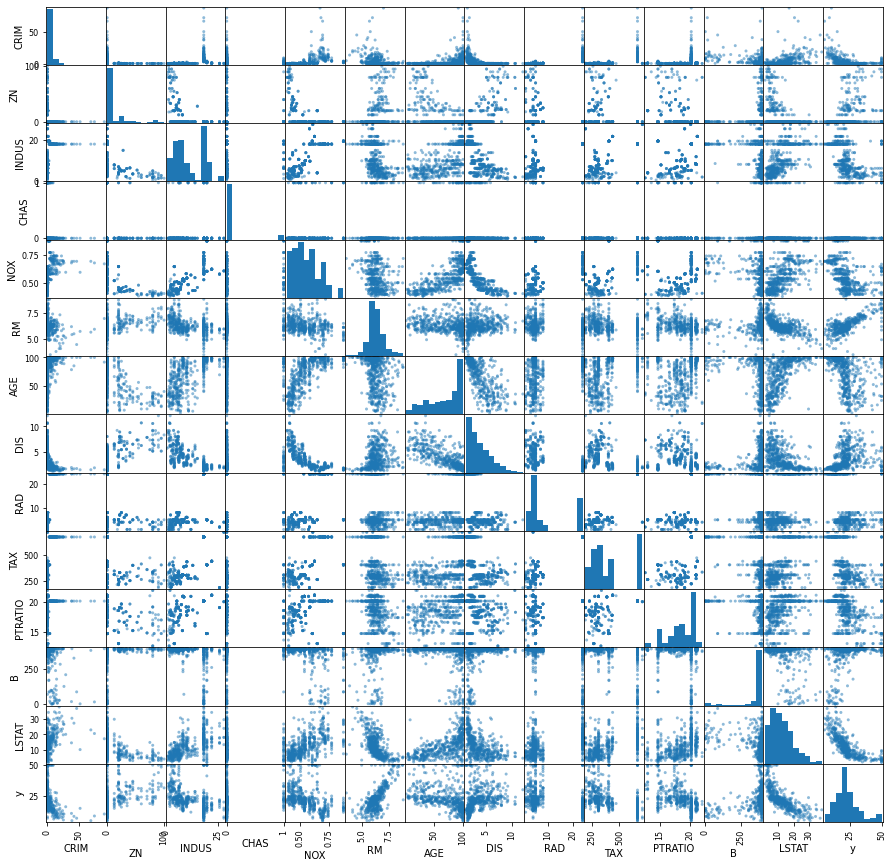

In [7]:
scatter = pd.plotting.scatter_matrix(X2, alpha=0.5, figsize = (15,15))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

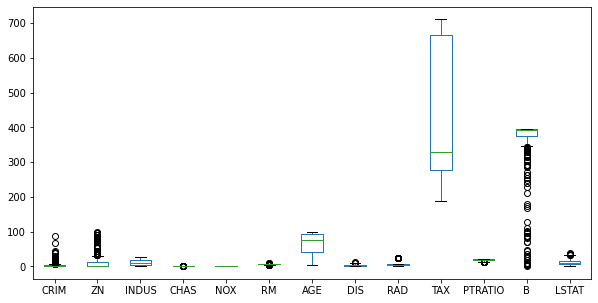

In [28]:
X_train.boxplot(grid=False, figsize=(10,5))

Замена экстремальных выбросов более 15IQR на значение границы 15IQR может немного улучшить результат модели (дополнительное задание для желающих)

Вся тренировка, настройка, оценка будет проходить на X_train, y_train. X_test, y_test - для финальной оценки

Дополнительно к имеющимся признакам сгенерируем полиномиальные признаки. В качестве модели возьмем линейную модель с L1 регуляризацией. В оценщике необходимо задать параметр max_iter = 50000, tol=0.01 - увеличить количество эпох, чтобы подойти ближе к точки минимума.

Используем конвейер, не забываем про масштабирование. Для масштабирования лучше использовать вариант не снижающий значимость выбросов.

Подобрать параметры - степень полинома 1-2, коэффициент регуляризации модели - степени 10 от -3 до 3.
Кросс-валидация на 5ти блоках, scoring = 'r2'

In [29]:
c = np.logspace(-3,3,7)

scaler = MinMaxScaler()
model = Pipeline([("poly", PolynomialFeatures(2)), ("scaler", scaler), ("classifier", Lasso(alpha=0.01, max_iter = 50000, tol=0.01))])
val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
#print(model.steps[2][1].get_params())
print(model.get_params().keys())
model.fit(X_train, y_train)

dict_keys(['memory', 'steps', 'verbose', 'poly', 'scaler', 'classifier', 'poly__degree', 'poly__include_bias', 'poly__interaction_only', 'poly__order', 'scaler__clip', 'scaler__copy', 'scaler__feature_range', 'classifier__alpha', 'classifier__copy_X', 'classifier__fit_intercept', 'classifier__max_iter', 'classifier__normalize', 'classifier__positive', 'classifier__precompute', 'classifier__random_state', 'classifier__selection', 'classifier__tol', 'classifier__warm_start'])


Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', MinMaxScaler()),
                ('classifier', Lasso(alpha=0.01, max_iter=50000, tol=0.01))])

Какие параметры оказались лучшими?
В качестве оценщика можно использовать grid_search.best_estimator_ 
Сколько получилось признаков после применения полиномизации? (у объекта PolynomialFeatures свойство .n_output_features_)
После регуляризации L1 сколько признаков значимо (имеют абсолютное значение больше единицы) Hint. sum([True,False,False]) = 1

In [30]:
params = {'classifier__alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'poly__degree':[1,2]}
grid_scores = GridSearchCV(model, cv=5, scoring='r2', param_grid=params)
grid_scores.fit(X_train, y_train)
print("Best params:", grid_scores.best_params_)
print("Number of features after polynomization: ", model.steps[0][1].n_output_features_)

Best params: {'classifier__alpha': 0.001, 'poly__degree': 2}
Number of features after polynomization:  105


Оценить качество на отложенной выборке. В качестве оценщика можно взять grid_search.best_estimator_.
Вывести RMSE, r2. R2 должно получиться 0.8 и больше

In [31]:
pred_y = grid_scores.predict(X_test)
print("RMSE", mean_squared_error(y_test, pred_y, squared=False))
print("R2", r2_score(y_test, pred_y))
# оценка R2 почти равна 0.8

RMSE 3.5817190953981637
R2 0.792220477768512


Проверить остатки на гомоскедастичность и нормальное распределение

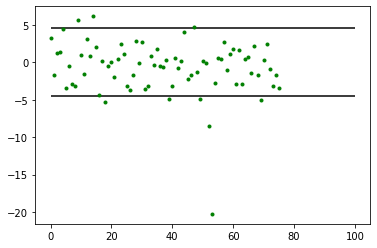

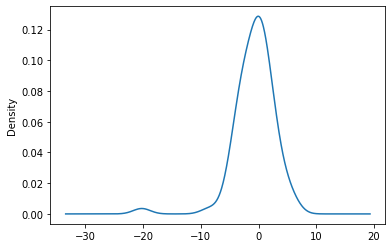

In [37]:
residuals = y_test - pred_y
plt.plot(residuals, "g.")
plt.hlines(-4.5, 0, 100)
plt.hlines(4.5, 0, 100)
# дисперсия не постоянна
df = pd.DataFrame(residuals)
df.plot(kind='kde', legend = False);
# похоже на нормальное распределение

-0.6871342817675995


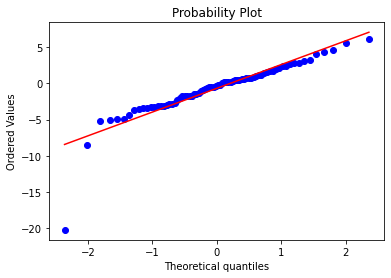

In [39]:
import scipy
qq = scipy.stats.probplot(residuals, dist="norm", plot=plt)
print(np.mean(residuals))
# среднее почти ноль

Видно, что остатки в целом остаются в промежутке [-4.5, 4.5], не считая выбросов (2 значительных на -20 и -10). По большей части формируют нормальное распределение

Увеличится ли качество на отложенной выборке, если для обучения взять больше образцов? (test_size 10% вместо 15% и модель из новых 5% )

RMSE 3.125809394462283
R2 0.8479331973219096


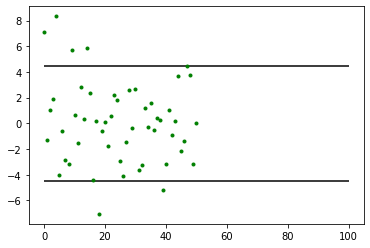

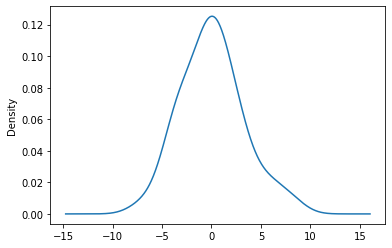

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=7)
model.fit(X_train, y_train)
grid_scores.fit(X_train, y_train)
pred_y = grid_scores.predict(X_test)
print("RMSE", mean_squared_error(y_test, pred_y, squared=False))
print("R2", r2_score(y_test, pred_y))
# оценка R2 лучше
residuals = y_test - pred_y
plt.plot(residuals, "g.")
plt.hlines(-4.5, 0, 100)
plt.hlines(4.5, 0, 100)
df = pd.DataFrame(residuals)
df.plot(kind='kde', legend = False);
# похоже на нормальное распределение

0.05649214435229992


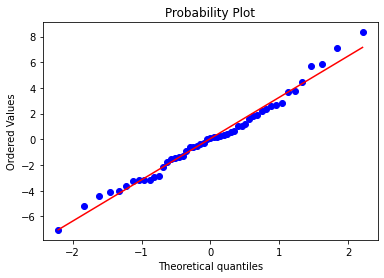

In [42]:
qq = scipy.stats.probplot(residuals, dist="norm", plot=plt)
print(np.mean(residuals))

Выбросов стало больше, но они в обе стороны уравновешиваются более-менее, потому что среднее близко к нулю. Чуть хуже похоже на нормальное распределение